In [1]:
import math
import pandas as pd
import numpy as np
from scipy.stats import stats, norm, skew
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.special import boxcox1p
import lightgbm as lgb
import xgboost as xgb
from fastprogress import master_bar, progress_bar
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV


%matplotlib inline
np.random.seed(2)

/Users/takato/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/takato/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can ins

In [2]:
plt.style.use('ggplot') 
matplotlib.rcParams['figure.figsize'] = (10,10)
plt.rcParams['font.size'] = 26 #font size
plt.rcParams['axes.linewidth'] = 1.5 #axis setting

In [3]:
# Load the data
train = pd.read_csv("./train_set.csv")
test = pd.read_csv("./test_set.csv")

print(train.shape)
print(test.shape)

/Users/takato/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (17,18,19,20,21,22,23,32,33,34,36,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(49108, 49)
(49108, 48)


In [4]:
train = train.drop(['Id',"SQUARE","X",'Y'], axis=1)
test = test.drop(["SQUARE",'X','Y'], axis=1)

train["GBA"] = np.log1p(train["GBA"])
test["GBA"] = np.log1p(test["GBA"])
train["LIVING_GBA"] = np.log1p(train["LIVING_GBA"])
test["LIVING_GBA"] = np.log1p(test["LIVING_GBA"])

train.columns

Index(['BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS', 'BEDRM',
       'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALEDATE', 'QUALIFIED', 'SALE_NUM',
       'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL',
       'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA',
       'GIS_LAST_MOD_DTTM', 'SOURCE', 'CMPLX_NUM', 'LIVING_GBA', 'FULLADDRESS',
       'CITY', 'STATE', 'ZIPCODE', 'NATIONALGRID', 'LATITUDE', 'LONGITUDE',
       'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CENSUS_TRACT', 'CENSUS_BLOCK',
       'WARD', 'QUADRANT', 'PRICE'],
      dtype='object')

In [5]:
train.dtypes

BATHRM                  int64
HF_BATHRM               int64
HEAT                   object
AC                     object
NUM_UNITS             float64
ROOMS                   int64
BEDRM                   int64
AYB                   float64
YR_RMDL               float64
EYB                     int64
STORIES               float64
SALEDATE               object
QUALIFIED              object
SALE_NUM                int64
GBA                   float64
BLDG_NUM                int64
STYLE                  object
STRUCT                 object
GRADE                  object
CNDTN                  object
EXTWALL                object
ROOF                   object
INTWALL                object
KITCHENS              float64
FIREPLACES              int64
USECODE                 int64
LANDAREA                int64
GIS_LAST_MOD_DTTM      object
SOURCE                 object
CMPLX_NUM             float64
LIVING_GBA            float64
FULLADDRESS            object
CITY                   object
STATE     

In [6]:
cols_with_none_as_nan = [
    "HEAT", 
    "AC",
    "SALEDATE",
    "STYLE",
    "STRUCT",
    "GRADE",
    "CNDTN",
    "EXTWALL",
    "ROOF",
    "INTWALL",
    "FULLADDRESS",
    "CITY",
    "STATE",
    "NATIONALGRID",
    "ASSESSMENT_SUBNBHD",
    "CENSUS_BLOCK",
    "QUADRANT"
    ]


# fill missing text fields with a default string
object_columns = train.select_dtypes(include=[object])
test_object_columns = test.select_dtypes(include=[object])

# for these colunms the string 'None' will be inserted in place of nan
for col in cols_with_none_as_nan:
    object_columns.loc[:, col] = object_columns.loc[:, col].fillna('None')
    test_object_columns.loc[:, col] = test_object_columns.loc[:, col].fillna('None')

remaining_fix = object_columns.isnull().sum()
print('Fixes remaining on train set\n', remaining_fix[remaining_fix>0])

remaining_fix = test_object_columns.isnull().sum()
print('Fixes remaining on test set\n',remaining_fix[remaining_fix>0])

/Users/takato/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Fixes remaining on train set
 Series([], dtype: int64)
Fixes remaining on test set
 Series([], dtype: int64)


In [7]:
numeric_columns = train.select_dtypes(include=[int, float])

remaining_fix = numeric_columns.isnull().sum()
print('Fixes remaining on train set\n',remaining_fix[remaining_fix>0])

test_numeric_columns = test.select_dtypes(include=[int, float])

remaining_fix = test_numeric_columns.isnull().sum()
print('Fixes remaining on test set\n',remaining_fix[remaining_fix>0])

Fixes remaining on train set
 NUM_UNITS     20053
AYB              56
YR_RMDL       20418
STORIES       20071
GBA           20053
KITCHENS      20053
CMPLX_NUM     29055
LIVING_GBA    29055
dtype: int64
Fixes remaining on test set
 NUM_UNITS     20263
AYB              56
YR_RMDL       20124
STORIES       20278
GBA           20263
KITCHENS      20264
CMPLX_NUM     28845
LIVING_GBA    28845
dtype: int64


In [8]:
cols_with_zero_as_nan = ['CMPLX_NUM',
                         'YR_RMDL',
                         'KITCHENS',
                         'NUM_UNITS',
                         'STORIES',
                         "AYB",
                         "GBA",
                         "LIVING_GBA"
                        ]

cols_with_mean_as_nan = [
                        ]


# for these colunms a zero will be inserted in place of nan
for col in cols_with_zero_as_nan:
    numeric_columns.loc[:, col] = numeric_columns.loc[:, col].fillna(0)
    test_numeric_columns.loc[:, col] = test_numeric_columns.loc[:, col].fillna(0)
    
# for these colunms the mean will be inserted in place of nan
for col in cols_with_mean_as_nan:
    numeric_columns.loc[:, col] = numeric_columns.loc[:, col].fillna(numeric_columns[col].mean())
    test_numeric_columns.loc[:, col] = test_numeric_columns.loc[:, col].fillna(test_numeric_columns[col].mean())


remaining_fix = numeric_columns.isnull().sum()
print('Fixes remaining on train set\n',remaining_fix[remaining_fix>0])

remaining_fix = test_numeric_columns.isnull().sum()
print('Fixes remaining on test set\n',remaining_fix[remaining_fix>0])

/Users/takato/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Fixes remaining on train set
 Series([], dtype: int64)
Fixes remaining on test set
 Series([], dtype: int64)


In [9]:
train_res = train[train["SOURCE"] == "Residential"]
train_con = train[train["SOURCE"] == "Condominium"]

test_res = test[test["SOURCE"] == "Residential"]
test_con = test[test["SOURCE"] == "Condominium"]


In [10]:
def fix_skewness(dataframe):
    skewed_feats = dataframe.apply(lambda x: abs(skew(x.dropna()))).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew': skewed_feats})
    skewness = skewness[abs(skewness) > 0.75].dropna()
    print("There are {} skewed numerical features to transform".format(skewness.shape[0]))
    print("\nSkew > .75 in numerical features: \n")
    print(skewness)
    # Fix skewness
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        if feat == 'PRICE': continue
        dataframe[feat] = boxcox1p(dataframe[feat], lam)
    print('Fixed skewness')

fix_skewness(numeric_columns)
fix_skewness(test_numeric_columns)

There are 15 skewed numerical features to transform

Skew > .75 in numerical features: 

                  Skew
FIREPLACES  221.596365
STORIES     178.135568
BLDG_NUM     83.740245
AYB          19.774995
PRICE        18.377059
ZIPCODE      16.634201
LANDAREA     13.677086
KITCHENS      4.464330
USECODE       2.245318
SALE_NUM      1.764593
NUM_UNITS     1.631241
BATHRM        1.369842
CMPLX_NUM     1.289017
ROOMS         1.227033
HF_BATHRM     0.990909


/Users/takato/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Fixed skewness
There are 14 skewed numerical features to transform

Skew > .75 in numerical features: 

                  Skew
FIREPLACES  167.931247
STORIES      95.583603
BLDG_NUM     83.740245
AYB          19.759579
ZIPCODE      16.335698
LANDAREA      4.606162
USECODE       2.265421
SALE_NUM      1.753085
NUM_UNITS     1.612659
KITCHENS      1.527030
BATHRM        1.321382
CMPLX_NUM     1.290780
ROOMS         1.210204
HF_BATHRM     1.138631
Fixed skewness


In [11]:
strings = np.array([])
for c in object_columns.columns:
    strings = np.append(strings, pd.unique(object_columns[c].values))

for c in test_object_columns.columns:
    strings = np.append(strings, pd.unique(test_object_columns[c].values))

print(len(strings), 'distinct labels generated')

labeler = LabelEncoder()
labeler.fit(strings.astype("str"))

for c in object_columns.columns:
    object_columns.loc[:,c] = labeler.transform(object_columns.loc[:,c])
    test_object_columns.loc[:,c] = labeler.transform(test_object_columns.loc[:,c])

object_columns[0:5]

135516 distinct labels generated


/Users/takato/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/takato/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,HEAT,AC,SALEDATE,QUALIFIED,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,...,SOURCE,FULLADDRESS,CITY,STATE,NATIONALGRID,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_BLOCK,WARD,QUADRANT
0,125609,125702,85058,125643,92729,125649,125678,125678,125568,125555,...,125645,18317,125682,125577,33683,125636,3868,1655,125686,125629
1,125609,125702,83385,125643,102182,125649,125678,125601,125568,125555,...,125645,17334,125682,125577,33959,125636,3868,1655,125686,125629
2,125693,125702,83796,125643,80543,125649,125537,125678,125667,125623,...,125645,17734,125682,125577,33961,125636,3868,1654,125686,125629
3,125693,125702,83557,125643,80543,125649,125537,125678,125568,125623,...,125645,17860,125682,125577,33919,125636,3868,1654,125686,125629
4,125609,125702,81023,125643,80543,125649,125602,125601,125568,125555,...,125645,18132,125682,125577,33851,125636,3868,1654,125686,125629


In [12]:
#object_columns.SOURCE.unique()
test_object_columns.SOURCE.unique()

array([125645, 125574])

In [13]:
# final train dataset
train_ds = object_columns.join(numeric_columns)
train_ds["PRICE"] = np.log1p(train_ds["PRICE"])

# separate with "SOURCE"
#train_ds = train_ds[train_ds["SOURCE"] == 125645] 
#train_ds = train_ds[train_ds["SOURCE"] == 125574] 
# test dataset
test_ds = test_object_columns.join(test_numeric_columns)
#test_ds = test_ds[test_ds["SOURCE"] == 125645] 
#test_ds = test_ds[test_ds["SOURCE"] == 125574] 
#correlation matrix
corrmat = train_ds.corr()['PRICE']
print(corrmat)
#f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, vmax=.8, square=True);

best_columns = corrmat[abs(corrmat) > 0.0].index
train_ds = train_ds[best_columns]
test_ds = test_ds[best_columns.drop('PRICE')]
best_columns

HEAT                  0.043877
AC                    0.006000
SALEDATE              0.424940
QUALIFIED            -0.143274
STYLE                -0.023896
STRUCT                0.110983
GRADE                 0.203400
CNDTN                 0.201421
EXTWALL              -0.038346
ROOF                  0.084217
INTWALL              -0.049569
GIS_LAST_MOD_DTTM     0.074413
SOURCE                0.074413
FULLADDRESS          -0.041676
CITY                  0.074438
STATE                -0.074438
NATIONALGRID         -0.184389
ASSESSMENT_NBHD      -0.007804
ASSESSMENT_SUBNBHD    0.085208
CENSUS_BLOCK         -0.078892
WARD                 -0.312115
QUADRANT             -0.220797
BATHRM                0.420796
HF_BATHRM             0.256117
NUM_UNITS             0.067921
ROOMS                 0.232533
BEDRM                 0.256575
AYB                   0.008895
YR_RMDL               0.131922
EYB                   0.223269
STORIES               0.109864
SALE_NUM              0.239483
GBA     

Index(['HEAT', 'AC', 'SALEDATE', 'QUALIFIED', 'STYLE', 'STRUCT', 'GRADE',
       'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'GIS_LAST_MOD_DTTM', 'SOURCE',
       'FULLADDRESS', 'CITY', 'STATE', 'NATIONALGRID', 'ASSESSMENT_NBHD',
       'ASSESSMENT_SUBNBHD', 'CENSUS_BLOCK', 'WARD', 'QUADRANT', 'BATHRM',
       'HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'YR_RMDL', 'EYB',
       'STORIES', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'KITCHENS', 'FIREPLACES',
       'USECODE', 'LANDAREA', 'CMPLX_NUM', 'LIVING_GBA', 'ZIPCODE', 'LATITUDE',
       'LONGITUDE', 'CENSUS_TRACT', 'PRICE'],
      dtype='object')

In [14]:
X_train = (train_ds.values[:,:-1])
y_train = np.asarray([[t] for t in (train_ds.values[:,-1])])
X_test = test_ds.values

print('Training set features shape', X_train.shape)
print('Training set labels shape', y_train.shape)
print('Test set shape', test_ds.shape)

Training set features shape (49108, 44)
Training set labels shape (49108, 1)
Test set shape (49108, 44)


In [15]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X_train)
X_train = pd.DataFrame(transformer.transform(X_train))
X_test = pd.DataFrame(transformer.transform(X_test))

In [16]:
def train_model(depth, learning_rate, n_estimators, model_type="xgb"):
    if model_type == 'xgb':
        model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                                 learning_rate=learning_rate, max_depth=depth, 
                                 min_child_weight=1.7817, n_estimators=n_estimators,
                                 reg_alpha=0.4640, reg_lambda=0.8571,
                                 subsample=0.5213, silent=1,
                                 random_state =7, nthread = -1)
    if model_type == 'lgb':
        model = lgb.LGBMRegressor(colsample_bytree=0.4603, min_gain_to_split=0.0468, 
                                 learning_rate=learning_rate, max_depth=depth, 
                                 min_child_weight=1.7817, n_estimators=n_estimators,
                                 reg_alpha=0.4640, reg_lambda=0.8571,
                                 subsample=0.5213, silent=1,
                                 random_state =7, nthread = -1)
        
    score = rmsle_cv(model)
    print(model_type, " score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))
    return score

#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train.flatten(), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

result = []
for depth in range(3, 5):
    for learning_rate in range(10, 20, 2):
        for n_estimators in range(4000, 5000, 500):
            score = train_model(depth, learning_rate/100, n_estimators, model_type='lgb')
            result.append([depth, learning_rate/100, n_estimators, score.mean(), score.std()])

# check results
result = pd.DataFrame(result, columns=['depth', 'learning_rate', 'n_estimators', 'score_mean', 'score_std'])
result.describe()

best = np.argmin(result['score_mean'].values)
print('Best params = \n', result.iloc[best])

In [17]:
# train with the best parameters
'''
depth = int(result.iloc[best]['depth'])
learning_rate = result.iloc[best]['learning_rate']
n_estimators = int(result.iloc[best]['n_estimators'])
'''

#depth = 5
#learning_rate = 0.5
#n_estimators = 5000

'''
model_lgb = lgb.LGBMRegressor(colsample_bytree=0.4603,learning_rate=learning_rate, max_depth=depth, 
                         min_child_weight=1.7817, n_estimators=n_estimators,
                         reg_alpha=0.4640, reg_lambda=0.8571,
                         subsample=0.5213, silent=1,
                         random_state =7, nthread = -1)
'''
model_lgb = lgb.LGBMRegressor(silent=1,
                         random_state =7, nthread = -1)

#score = rmsle_cv(model_lgb)
#print("lgb score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))

model_lgb.fit(X_train, y_train.flatten())
y_pred = model_lgb.predict(X_train)

print('RMSLE LGB = ', rmsle(y_train, y_pred))

RMSLE LGB =  0.307134505640744


In [18]:
print(model_lgb)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, nthread=-1, num_leaves=31,
       objective=None, random_state=7, reg_alpha=0.0, reg_lambda=0.0,
       silent=1, subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [31]:
param_grid = {
    'learning_rate': [0.05,0.1],
    'n_estimators': [1000,1500,2000,2500]
}

gbm = GridSearchCV(model_lgb, param_grid, cv=5)

In [32]:
gbm.fit(X_train, y_train.flatten())

print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.05, 'n_estimators': 1500}


In [33]:
y_pred = model_lgb.predict(X_train)

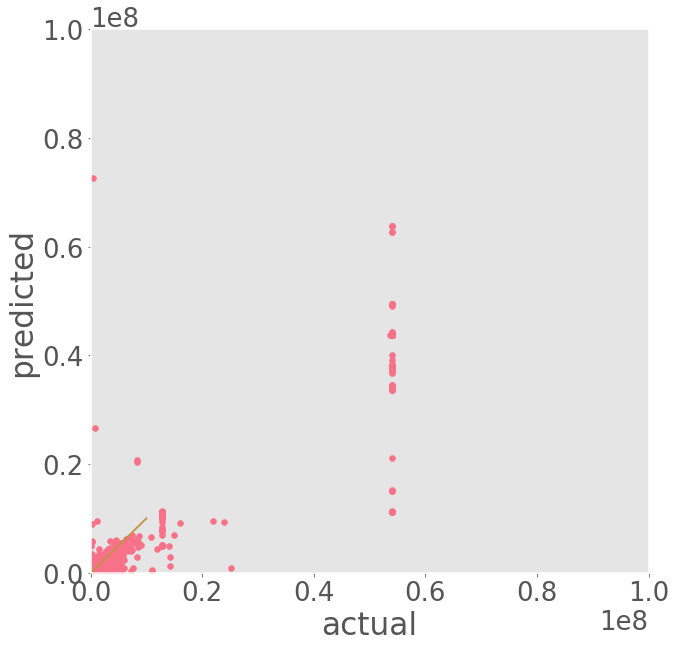

In [34]:
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 100_000_000)
plt.ylim(0, 100_000_000)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.grid()
plt.plot([(0, 0), (10_000_000, 10_000_000)], [(0, 0), (10_000_000, 10_000_000)])
plt.show()

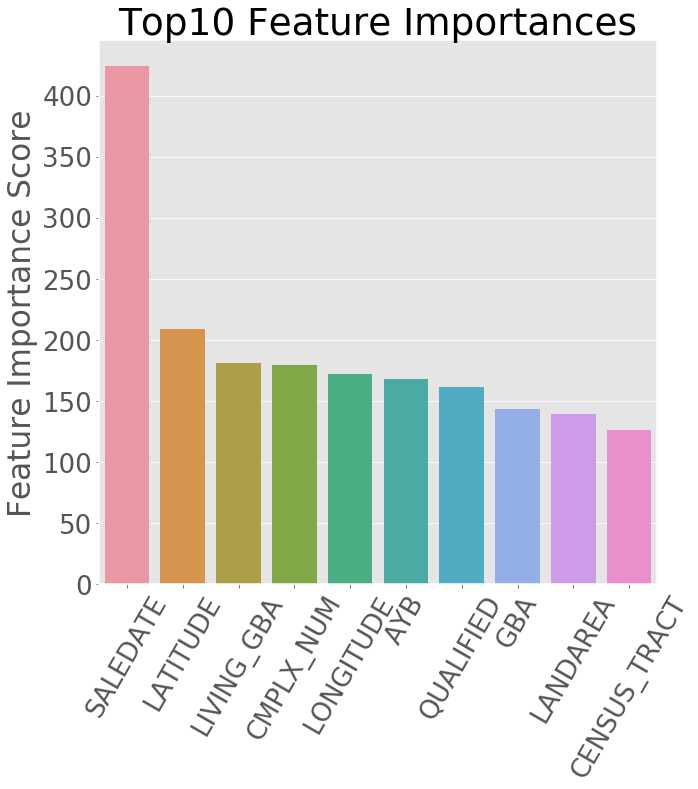

         0    1         2    3         4         5         6         7   \
0  0.000000  0.0  0.454803  0.0  0.270199  0.047619  0.863636  1.604167   
1  0.000000  0.0 -0.138249  0.0  0.479851  0.047619  0.863636  0.000000   
2  4.941176  0.0  0.007444  0.0 -0.000067  0.047619 -0.738636  1.604167   
3  4.941176  0.0 -0.077278  0.0 -0.000067  0.047619 -0.738636  1.604167   
4  0.000000  0.0 -0.975541  0.0 -0.000067  0.047619  0.000000  0.000000   

         8         9     ...           34        35        36        37   38  \
0 -0.062500 -1.079365    ...     0.635014  2.492027  1.482961  0.116738  0.0   
1 -0.062500 -1.079365    ...     0.000000  2.492027 -0.373034  0.292115  0.0   
2  1.484375  0.000000    ...     0.635014  1.000000  1.482961  0.166623  0.0   
3 -0.062500  0.000000    ...     0.000000  0.000000 -0.373034  0.011964  0.0   
4 -0.062500 -1.079365    ...     0.635014  1.000000  1.482961  0.011964  0.0   

    39        40        41        42        43  
0  0.0 -0.083339  0

In [35]:
predictors = [x for x in train_ds.columns if x not in ["PRICE", "Id"]]
feat_imp = pd.Series(model_lgb.feature_importances_, predictors).sort_values(ascending=False)
sns.set_palette("husl")
sns.barplot(feat_imp.head(10).index, feat_imp.head(10).values)
plt.title('Top10 Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xticks(rotation=60)
plt.show()
print(X_train.head())

In [36]:
result = []
for depth in range(3, 5):
    for learning_rate in range(3, 5, 1):
        for n_estimators in range(1200, 2000, 200):
            score = train_model(depth, learning_rate/100, n_estimators, model_type='xgb')
            result.append([depth, learning_rate/100, n_estimators, score.mean(), score.std()])

xgb  score: depth=3 lr=0.03 est=1200 -> mean:0.51496 std:0.1770
xgb  score: depth=3 lr=0.03 est=1400 -> mean:0.51468 std:0.1757
xgb  score: depth=3 lr=0.03 est=1600 -> mean:0.51439 std:0.1750
xgb  score: depth=3 lr=0.03 est=1800 -> mean:0.51429 std:0.1744
xgb  score: depth=3 lr=0.04 est=1200 -> mean:0.51579 std:0.1741
xgb  score: depth=3 lr=0.04 est=1400 -> mean:0.51596 std:0.1727
xgb  score: depth=3 lr=0.04 est=1600 -> mean:0.51555 std:0.1716
xgb  score: depth=3 lr=0.04 est=1800 -> mean:0.51543 std:0.1717
xgb  score: depth=4 lr=0.03 est=1200 -> mean:0.51087 std:0.1744
xgb  score: depth=4 lr=0.03 est=1400 -> mean:0.51048 std:0.1733
xgb  score: depth=4 lr=0.03 est=1600 -> mean:0.51081 std:0.1730
xgb  score: depth=4 lr=0.03 est=1800 -> mean:0.50998 std:0.1731
xgb  score: depth=4 lr=0.04 est=1200 -> mean:0.51438 std:0.1720
xgb  score: depth=4 lr=0.04 est=1400 -> mean:0.51364 std:0.1713
xgb  score: depth=4 lr=0.04 est=1600 -> mean:0.51517 std:0.1708
xgb  score: depth=4 lr=0.04 est=1800 -> 

# check results
result = pd.DataFrame(result, columns=['depth', 'learning_rate', 'n_estimators', 'score_mean', 'score_std'])
result.describe()

best = np.argmin(result['score_mean'].values)
print('Best params = \n', result.iloc[best])

In [ ]:
# train with the best parameters
'''
depth = int(result.iloc[best]['depth'])
learning_rate = result.iloc[best]['learning_rate']
n_estimators = int(result.iloc[best]['n_estimators'])
'''

depth = 5
learning_rate = 1.0
n_estimators = 5000
model_xgb = xgb.XGBRegressor(learning_rate=learning_rate, max_depth=depth, 
                         min_child_weight=1.7817, n_estimators=n_estimators,silent=1,
                         random_state =7, nthread = -1)



score = rmsle_cv(model_xgb)
print("XGB score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))

model_xgb.fit(X_train, y_train.flatten())
y_pred = model_xgb.predict(X_train)

print('RMSLE XGB = ', rmsle(y_train, y_pred))

In [ ]:
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 100_000_000)
plt.ylim(0, 100_000_000)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.grid()
plt.plot([(0, 0), (10_000_000, 10_000_000)], [(0, 0), (10_000_000, 10_000_000)])
plt.show()

In [ ]:
predictors = [x for x in train_ds.columns if x not in ["PRICE", "Id"]]
feat_imp = pd.Series(model_xgb.feature_importances_, predictors).sort_values(ascending=False)
sns.set_palette("husl")
sns.barplot(feat_imp.head(10).index, feat_imp.head(10).values)
plt.title('Top10 Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xticks(rotation=60)
plt.show()
print(X_train.head())

In [ ]:
avg_predict = (model_lgb.predict(X_train) + model_xgb.predict(X_train)) / 2
y_pred = avg_predict

plt.figure(figsize=(8, 8))
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 200_000_000)
plt.ylim(0, 200_000_000)
plt.xlabel('actual', fontsize=26)
plt.ylabel('predicted', fontsize=26)
plt.plot([(0, 0), (10_000_000, 10_000_000)], [(0, 0), (10_000_000, 10_000_000)])
plt.show()

print('RMSLE averaged = ', rmsle(y_train, y_pred))

In [ ]:
# Submission
print(np.expm1(model_xgb.predict(X_test)[0:5]))
print(np.expm1(model_lgb.predict(X_test)[0:5]))
avg_predict = (model_xgb.predict(X_test) + model_lgb.predict(X_test)) / 2
subm_predict = np.expm1(avg_predict)

dsubm_predict = pd.DataFrame()
dsubm_predict['Id'] = test.values[:,0]
dsubm_predict["PRICE"] = pd.DataFrame(subm_predict)

dsubm_predict.to_csv('submission.csv', index=False)
dsubm_predict[0:10]

In [ ]:
dsubm_predict